https://github.com/jacobgil/keras-cam/blob/master/cam.py

In [1]:
import tensorflow as tf
from tensorflow.python.keras import activations
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import backend as K
import numpy as np
from PIL import Image

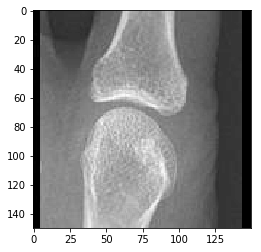

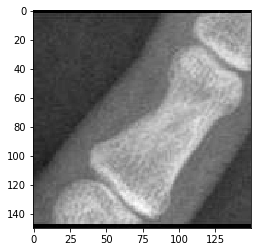

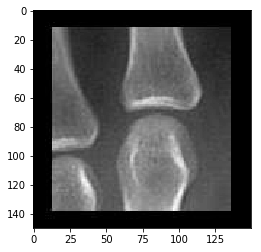

In [2]:
import h5py
from matplotlib import pyplot as plt
# load test images
with h5py.File('/cluster/home/rohrbjan/joint_scoring/img_test_regression.h5', 'r') as hf:
    img_test = hf['img_test_regression'][:]

plt.close()
for i in range(3):    
    plt.imshow(img_test[i].squeeze(), cmap='gray')
    plt.show()  

In [3]:
with h5py.File('/cluster/home/rohrbjan/joint_scoring/labels_test_regression.h5', 'r') as hf:
    labels_test = hf['labels_test_regression'][:]
    
print(labels_test[:3])

[ 0.  0.  0.]


In [5]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

imgs_rgb = []

for i, img in enumerate(img_test):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72298*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    imgs_rgb.append(dat)

Converting train images to RGB, 26.28 % finished


In [6]:
imgs_rgb = np.array(imgs_rgb)

In [7]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

imgs_rgb = [preprocess_input(x) for x in imgs_rgb.astype("float32")]

In [8]:
imgs = np.array(imgs_rgb)

In [4]:
from tensorflow.python.keras import backend as K

def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [10]:
# load regression model
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/cluster/home/rohrbjan/joint_scoring/models/20171128_000703.h5", custom_objects={"crps":crps})

In [11]:
loaded_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 74, 74, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 74, 74, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [95]:
from tensorflow.python.keras.models import Model
layer_name = 'conv2d_75'#'conv2d_29'
model = Model(inputs=loaded_model.input, 
              outputs=loaded_model.get_layer(layer_name).output)

In [102]:
def attention_map(img, img_grey):
    width, height, _ = img.shape
    img = img.reshape(1, 150, 150, 3)
    embeddings = model.predict(img)
    conv_outputs = embeddings[0, :, :, :]
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    class_weights = loaded_model.get_layer('batch_normalization_29').get_weights()[0]
    for i, w in enumerate(class_weights):
        cam +=  conv_outputs[:, :, i] #w *
    cam /= np.max(cam)
    cam /= np.max(cam)
    heatmap = Image.fromarray(np.uint8(plt.cm.viridis(cam)*255))
    heatmap = heatmap.resize((width, height))
    heatmap.putalpha(75)
    img_org = Image.fromarray(np.uint8(img_grey.squeeze()))
    img_org = img_org.convert('RGBA')
    img_new = Image.alpha_composite(im1=img_org, im2=heatmap)
    return img_new

In [103]:
len(imgs_rgb)

19709

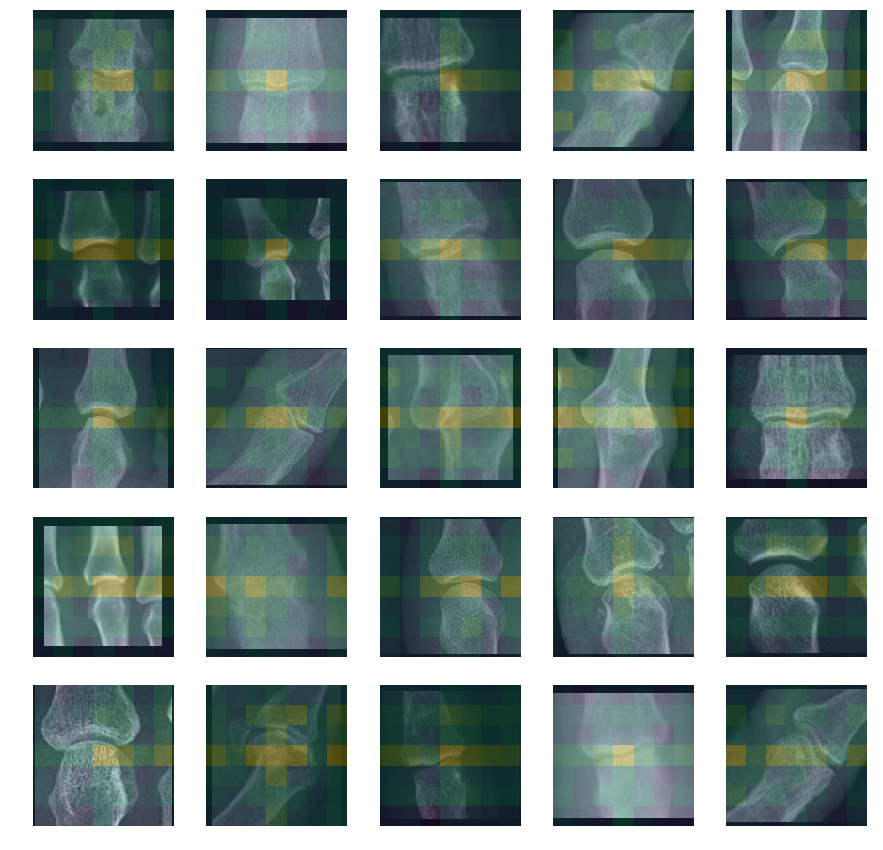

In [105]:
f, axarr = plt.subplots(5, 5, figsize=(15,15))

np.random.seed(seed=1)

for i in range(5):
    for j in range(5):
        index = np.random.randint(0, 19709)
        axarr[i, j].imshow(attention_map(imgs_rgb[index], img_test[index]))
        axarr[i, j].axis('off')

plt.show()